In [49]:
import numpy as np
import gym
import tensorflow as tf
from skimage.transform import resize
from skimage.color import rgb2gray

class Atari:
    """Wrapper for the environment provided by gym"""

    def __init__(self, env_name, frame_height, frame_width, agent_history_length=4, no_op_steps=10):
        self.env_name = env_name
        self.env = gym.make(env_name)
        print("The environment has the following {} actions: {}".format(self.env.action_space.n,
                                                                        self.env.unwrapped.get_action_meanings()))

        # self.frame_processor = ProcessFrame()
        self.current_state = np.empty((frame_height, frame_width, agent_history_length), dtype=np.uint8)
        self.last_lives = 0
        self.no_op_steps = no_op_steps
        self.agent_history_length = agent_history_length
        self.action_space_size = self.env.action_space.n
        self.game_shape = self.env.observation_space.shape
        self.is_graphical = True if len(self.game_shape) > 1 else False
        self.frame_height = frame_height if self.is_graphical else self.game_shape[0]
        self.frame_width = frame_width if self.is_graphical else 1

    def reset(self, evaluation=False):
        """
        Args:
            evaluation: A boolean saying whether the agent is evaluating or training
        Resets the environment and stacks four frames ontop of each other to
        create the first state
        """
        frame = self.env.reset()
        self.last_lives = 0
        terminal_life_lost = True  # Set to true so that the agent starts
        # with a 'FIRE' action when evaluating
        if evaluation:
            for _ in range(np.random.randint(1, self.no_op_steps)):
                frame, _, _, _ = self.env.step(1)  # Action 'Fire'
        else:
            frame, _, _, _ = self.env.step(1)

        processed_frame = self.process(frame)
        for i in range(self.agent_history_length):
            self.update_current_state(processed_frame)

        return terminal_life_lost

    def process(self, frame):
        # returns a (height, width, 1) array
        if self.is_graphical:
            # frame = frame[34:200, 0:160, :]
            frame = resize(frame, (self.frame_height, self.frame_width))
            frame = rgb2gray(frame)
            frame = np.uint8(frame*255)
        return frame

    def step(self, action):
        """
        Args:
            action: Integer, action the agent performs
        Performs an action and observes the reward and terminal state from the environment
        """
        new_frame, reward, terminal, info = self.env.step(action)  # (5★)

        if info['ale.lives'] < self.last_lives:
            terminal_life_lost = True
        else:
            terminal_life_lost = terminal
        self.last_lives = info['ale.lives']

        processed_new_frame = self.process(new_frame)
        self.update_current_state(processed_new_frame)

        return processed_new_frame, reward, terminal, terminal_life_lost, new_frame

    def get_current_state(self):
        return self.current_state

    def update_current_state(self, frame):
        self.current_state = np.append(self.current_state[:, :, 1:], np.expand_dims(frame, axis=2), axis=2)


In [50]:
import tensorflow as tf
from keras import layers, callbacks
from keras.models import Model
from keras.optimizers import RMSprop, Adam
from keras import backend as K
import numpy as np

from keras.models import Sequential, Model
from keras.layers.core import Dense, Flatten, Lambda
from keras.layers import Activation, Input
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Add
from keras.initializers import VarianceScaling
# from numba import *

class QLearner:
    def __init__(self, n_actions, learning_rate=0.00001,
                 frame_height=84, frame_width=84, agent_history_length=4,
                 batch_size=32, gamma=0.99, use_double_model=True):
        self.n_actions = n_actions
        self.learning_rate = learning_rate
        self.frame_height = frame_height
        self.frame_width = frame_width
        self.agent_history_length = agent_history_length
        self.batch_size = batch_size
        self.gamma = gamma
        self.use_double_model = use_double_model
        # self.punishment = punishment

        self.main_learner = DQN(self.n_actions, self.learning_rate,
                                self.frame_height, self.frame_width, agent_history_length)

        self.target_learner = DQN(self.n_actions, learning_rate,
                                  self.frame_height, self.frame_width, agent_history_length)

        self.targets = np.zeros((batch_size,))
        self.set_computation_device()

        # self.tbCallBack = [callbacks.TensorBoard(log_dir='./output/Tensorboards', histogram_freq=0, write_graph=True, write_images=True)]
        self.tbCallBack = None

    @staticmethod
    def set_computation_device():
        num_cores = 14
        GPU = True

        if GPU:
            num_GPU = 1
            num_CPU = 1
        else:
            num_CPU = 1
            num_GPU = 0

        config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                                inter_op_parallelism_threads=num_cores,
                                allow_soft_placement=True,
                                device_count={'CPU': num_CPU,
                                              'GPU': num_GPU}
                                )

        session = tf.Session(config=config)
        K.set_session(session)

    # @jit
    def predict(self, states):
        actions_mask = np.ones((states.shape[0], self.n_actions))
        return self.main_learner.model.predict([states, actions_mask])  # separate old model to predict

    # @jit
    def train(self, current_state_batch, actions, rewards, next_state_batch, terminal_flags):

        self.calculate_target_q_values(next_state_batch, terminal_flags, rewards)

        one_hot_actions = np.eye(self.n_actions)[np.array(actions).reshape(-1)]
        one_hot_targets = one_hot_actions * self.targets[:, None]

        history = self.main_learner.model.fit([current_state_batch, one_hot_actions], one_hot_targets,
                                 epochs=1, batch_size=self.batch_size, verbose=0, callbacks=self.tbCallBack)

        return history.history['loss'][0]

    # @jit
    def update_target_network(self):
        if self.use_double_model:
            print('Updating the target network')
            self.target_learner.model.set_weights(self.main_learner.model.get_weights())
        else:
            print('Doubling is off, no need to update target network')

    # @jit
    def calculate_target_q_values(self, next_state_batch, terminal_flags, rewards):
        actions_mask = np.ones((self.batch_size, self.n_actions))
        q_next_state = self.main_learner.model.predict([next_state_batch, actions_mask])  # separate old model to predict
        action, _ = self.action_selection_policy(q_next_state)
        if self.use_double_model:
            q_target = self.target_learner.model.predict([next_state_batch, actions_mask])  # separate old model to predict
        else:
            q_target = q_next_state

        for i in range(self.batch_size):
            if terminal_flags[i]:
                self.targets[i] = rewards[i]
            else:
                self.targets[i] = rewards[i] + self.gamma * q_target[i, action[i]]

    # @jit
    def action_selection_policy(self, q_values):
        # v = q_values - q_values.min(axis=1).reshape((-1, 1))
        # v += 1.0
        # sums = v.sum(axis=1).reshape((-1, 1))
        # v = v / sums
        # v = np.cumsum(v, axis=1)
        #
        # res = np.empty(q_values.shape[0], dtype=np.int32)
        # r = np.random.rand(q_values.shape[0])
        # for i in range(q_values.shape[0]):
        #     res[i] = np.argwhere(v[i,:] >= r[i])[0,0]

        res = np.argmax(q_values, axis=1)
        return res, q_values[0,res][0]

class DQN:

    def __init__(self, n_actions, learning_rate=0.00001,
                 frame_height=84, frame_width=84, agent_history_length=4):
        self.n_actions = n_actions
        self.learning_rate = learning_rate
        self.frame_height = frame_height
        self.frame_width = frame_width
        self.agent_history_length = agent_history_length

        input_shape = (frame_height, frame_width, agent_history_length)
        # model = self.legacy_model(input_shape, self.n_actions)
        # model = self.dueling_convnet(input_shape, self.n_actions)
        # model = self.my_convnet(input_shape, self.n_actions)
        model = self.nature_convnet(input_shape, self.n_actions)
        # model = self.small_nature_convnet(input_shape, self.n_actions)
        # model = self.sim_nature_convnet(input_shape, self.n_actions)
        # model = self.modular_convnet(input_shape, self.n_actions)

        model.summary()

        optimizer = RMSprop(lr=self.learning_rate, rho=0.95)
        # optimizer = Adam(lr=self.learning_rate)
        model.compile(optimizer, loss=tf.losses.huber_loss)

        self.model = model


    def huber_loss(self, y, q_value):
        error = K.abs(y - q_value)
        quadratic_part = K.clip(error, 0.0, 1.0)
        linear_part = error - quadratic_part
        loss = K.mean(0.5 * K.square(quadratic_part) + linear_part)
        return loss


    @staticmethod
    def legacy_model(input_shape, num_actions):
        frames_input = layers.Input(input_shape, name='inputs')
        actions_input = layers.Input((num_actions,), name='action_mask')

        normalized = layers.Lambda(lambda x: x / 255.0, name='norm')(frames_input)

        conv_1 = layers.convolutional.Conv2D(
            64, (8, 8), strides=(2, 2), activation='relu', kernel_initializer='VarianceScaling')(normalized)
        conv_2 = layers.convolutional.Conv2D(
            32, (4, 4), strides=(2, 2), activation='relu', kernel_initializer='VarianceScaling')(conv_1)
        conv_3 = layers.convolutional.Conv2D(
            32, (3, 3), strides=(1, 1), activation='relu', kernel_initializer='VarianceScaling')(conv_2)
        conv_4 = layers.convolutional.Conv2D(
            32, (7, 7), strides=(1, 1), activation='relu', kernel_initializer='VarianceScaling')(conv_3)

        conv_flattened = layers.core.Flatten()(conv_4)
        hidden = layers.Dense(256, activation='relu')(conv_flattened)
        output = layers.Dense(num_actions)(hidden)

        filtered_output = layers.Multiply(name='QValue')([output, actions_input])

        model = Model(inputs=[frames_input, actions_input], outputs=filtered_output)

        return model

    @staticmethod
    def linear(input_shape, num_actions):
        model = Sequential()
        model.add(Flatten(
            input_shape=input_shape))
        model.add(Dense(
            num_actions,
            activation=None))
        return model

    @staticmethod
    def convnet(input_shape, num_actions):
        model = Sequential()
        model.add(Conv2D(16, 8, strides=(4, 4), activation='relu', input_shape=input_shape))
        model.add(Conv2D(32, 4, strides=(2, 2), activation='relu'))
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dense(num_actions, activation=None))
        return model

    @staticmethod
    def convnet_bn(input_shape, num_actions):
        frames_input = Input(shape=input_shape)
        normalized = layers.Lambda(lambda x: x / 255.0, name='norm')(frames_input)
        net = Conv2D(16, 8, strides=(4, 4), activation='relu')(normalized)
        net = Conv2D(32, 4, strides=(2, 2), activation='relu')(net)
        net = Flatten()(net)
        net = Dense(32, activation='relu')(net)
        net = BatchNormalization()(net)
        net = Dense(num_actions, activation=None)(net)
        model = DQN.add_action_mask_layer(net, frames_input, num_actions)

        return model

    @staticmethod
    def simpler_convnet(input_shape, num_actions):
        frames_input = Input(shape=input_shape)
        normalized = layers.Lambda(lambda x: x / 255.0, name='norm')(frames_input)
        net = Conv2D(16, 8, strides=(4, 4), activation='relu')(normalized)
        net = Conv2D(32, 4, strides=(2, 2), activation='relu')(net)
        net = Flatten()(net)
        net = Dense(32, activation='relu')(net)
        net = Dense(num_actions, activation=None)(net)
        model = DQN.add_action_mask_layer(net, frames_input, num_actions)

        return model

    @staticmethod
    def nature_convnet(input_shape, num_actions):
        frames_input = Input(shape=input_shape)
        normalized = layers.Lambda(lambda x: x / 255.0, name='norm')(frames_input)
        net = Conv2D(32, 8, strides=(4, 4), activation='relu')(normalized)
        net = Conv2D(64, 4, strides=(2, 2), activation='relu')(net)
        net = Conv2D(64, 3, strides=(1, 1), activation='relu')(net)
        net = Flatten()(net)
        net = Dense(512, activation='relu')(net)
        net = Dense(num_actions, activation=None)(net)
        model = DQN.add_action_mask_layer(net, frames_input, num_actions)

        return model

    @staticmethod
    def small_nature_convnet(input_shape, num_actions):
        frames_input = Input(shape=input_shape)
        normalized = layers.Lambda(lambda x: x / 255.0, name='norm')(frames_input)
        net = Conv2D(8, 8, strides=(4, 4), activation='relu')(normalized)
        net = Conv2D(16, 4, strides=(2, 2), activation='relu')(net)
        net = Conv2D(16, 3, strides=(1, 1), activation='relu')(net)
        net = Flatten()(net)
        net = Dense(512, activation='relu')(net)
        net = Dense(num_actions, activation=None)(net)
        model = DQN.add_action_mask_layer(net, frames_input, num_actions)

        return model


    @staticmethod
    def dueling_convnet(input_shape, num_actions):
        initializer = VarianceScaling(scale=2.0)
        frames_input = Input(shape=input_shape)
        normalized = layers.Lambda(lambda x: x / 255.0, name='norm')(frames_input)

        net = Conv2D(32, (8, 8), strides=(4, 4), activation='relu', kernel_initializer=initializer, padding='valid',
                     use_bias=False)(normalized)
        net = Conv2D(64, (4, 4), strides=(2, 2), activation='relu', kernel_initializer=initializer, padding='valid',
                     use_bias=False)(net)
        net = Conv2D(64, (3, 3), strides=(1, 1), activation='relu', kernel_initializer=initializer, padding='valid',
                     use_bias=False)(net)
        net = Conv2D(1024, (7, 7), strides=(1, 1), activation='relu', kernel_initializer=initializer, padding='valid',
                     use_bias=False)(net)

        net = Flatten()(net)
        advt = Dense(256, kernel_initializer=initializer)(net)
        # advt = Dense(50, kernel_initializer=initializer)(net)

        advt = Dense(num_actions)(advt)
        value = Dense(256, kernel_initializer=initializer)(net)
        # value = Dense(50, kernel_initializer=initializer)(net)

        value = Dense(1)(value)
        # now to combine the two streams
        advt = Lambda(lambda advt: advt - tf.reduce_mean(advt, axis=-1, keep_dims=True))(advt)
        value = Lambda(lambda value: tf.tile(value, [1, num_actions]))(value)
        final = Add()([value, advt])

        model = DQN.add_action_mask_layer(final, frames_input, num_actions)

        # model = Model(inputs=inputs, outputs=final)
        return model

    @staticmethod
    def my_convnet(input_shape, num_actions):
        initializer = VarianceScaling(scale=2.0)
        frames_input = Input(shape=input_shape)
        normalized = layers.Lambda(lambda x: x / 255.0, name='norm')(frames_input)

        net = Conv2D(32, (8, 8), strides=(4, 4),
                     activation='relu', kernel_initializer=initializer,
                     padding='valid', use_bias=False)(normalized)
        net = Conv2D(64, (4, 4), strides=(2, 2),
                     activation='relu', kernel_initializer=initializer,
                     padding='valid', use_bias=False)(net)
        net = Conv2D(64, (4, 4), strides=(1, 1),
                     activation='relu', kernel_initializer=initializer,
                     padding='valid', use_bias=False)(net)
        net = Conv2D(64, (4, 4), strides=(1, 1),
                     activation='relu', kernel_initializer=initializer,
                     padding='valid', use_bias=False)(net)
        net = Conv2D(128, (3, 3), strides=(1, 1),
                     activation='relu', kernel_initializer=initializer,
                     padding='valid', use_bias=False)(net)

        net = Flatten()(net)
        advt = Dense(32, kernel_initializer=initializer)(net)
        # advt = Dense(50, kernel_initializer=initializer)(net)

        advt = Dense(num_actions)(advt)
        value = Dense(32, kernel_initializer=initializer)(net)
        # value = Dense(50, kernel_initializer=initializer)(net)

        value = Dense(1)(value)
        # now to combine the two streams
        advt = Lambda(lambda advt: advt - tf.reduce_mean(advt, axis=-1, keep_dims=True))(advt)
        value = Lambda(lambda value: tf.tile(value, [1, num_actions]))(value)
        final = Add()([value, advt])

        model = DQN.add_action_mask_layer(final, frames_input, num_actions)

        # model = Model(inputs=inputs, outputs=final)
        return model

    @staticmethod
    def modular_convnet(input_shape, num_actions):
        frames_input = Input(shape=input_shape)
        normalized = layers.Lambda(lambda x: x / 255.0, name='norm')(frames_input)
        # Vision
        net = Conv2D(32, 8, strides=(4, 4), activation='relu')(normalized)
        net = Conv2D(64, 4, strides=(2, 2), activation='relu')(net)
        net = Conv2D(64, 3, strides=(1, 1), activation='relu')(net)
        net = Flatten()(net)

        # Reasoning
        net = Dense(256, activation='tanh')(net)
        net = Dense(64, activation='tanh')(net)

        # Action decision maker
        net = Dense(32, activation='relu')(net)
        net = Dense(num_actions, activation=None)(net)

        model = DQN.add_action_mask_layer(net, frames_input, num_actions)

        return model

    @staticmethod
    def sim_nature_convnet(input_shape, num_actions):
        frames_input = Input(shape=input_shape)
        normalized = layers.Lambda(lambda x: x / 255.0, name='norm')(frames_input)
        # net = Conv2D(32, 8, strides=(4, 4), activation='relu')(normalized)
        # net = Conv2D(64, 4, strides=(2, 2), activation='relu')(net)
        # net = Conv2D(64, 3, strides=(1, 1), activation='relu')(net)

        net = Conv2D(64, 16, strides=(10, 10), activation='relu')(normalized)

        net = Flatten()(net)
        net = Dense(512, activation='relu')(net)
        net = Dense(num_actions, activation=None)(net)
        model = DQN.add_action_mask_layer(net, frames_input, num_actions)

        return model


    @staticmethod
    def add_action_mask_layer(final, frames_input, num_actions):
        actions_input = layers.Input((num_actions,), name='action_mask')
        filtered_output = layers.Multiply(name='QValue')([final, actions_input])
        model = Model(inputs=[frames_input, actions_input], outputs=filtered_output)
        return model


In [51]:
import numpy as np
import os
import datetime
# from memory import ReplayMemory
# from learner import QLearner
from keras.models import model_from_json
# from numba import *


class Player:
    def __init__(self, game_env, agent_history_length, total_memory_size, batch_size,
                 learning_rate, init_epsilon, end_epsilon, minimum_observe_episode,
                 update_target_frequency, train_frequency, gamma, exploratory_memory_size,
                 punishment, reward_extrapolation_exponent, linear_exploration_exponent, use_double):

        self.n_actions = game_env.action_space_size
        self.init_epsilon = init_epsilon
        self.epsilon = init_epsilon
        self.end_epsilon = end_epsilon
        self.minimum_observe_episodes = minimum_observe_episode
        self.update_target_frequency = update_target_frequency
        self.game_env = game_env
        self.train_frequency = train_frequency
        self.exploratory_memory_size = exploratory_memory_size
        self.linear_exploration_exponent = linear_exploration_exponent
        self.use_double_model = use_double

        if reward_extrapolation_exponent < 0:
            use_estimated_reward = False
        else:
            use_estimated_reward = True

        self.memory = ReplayMemory(self.game_env.frame_height, self.game_env.frame_width,
                                   agent_history_length, total_memory_size,
                                   batch_size, self.game_env.is_graphical,
                                   punishment=punishment, use_estimated_reward=use_estimated_reward,
                                   reward_extrapolation_exponent=reward_extrapolation_exponent,
                                   linear_exploration_exponent=self.linear_exploration_exponent)

        self.learner = QLearner(self.n_actions, learning_rate, self.game_env.frame_height, self.game_env.frame_width,
                                agent_history_length, gamma=gamma, use_double_model=self.use_double_model)
        self.losses = []
        self.q_values = []

        # self.actuator = ???

    # @jit
    def take_action(self, current_state, total_frames, evaluation=False):
        if (np.random.rand() <= self.epsilon) or (total_frames < self.exploratory_memory_size) and (not evaluation):
            action = np.random.randint(0, self.n_actions)
        else:
            current_state = np.expand_dims(current_state, axis=0)
            q_values = self.learner.predict(current_state)

            action, q_value = self.learner.action_selection_policy(q_values)
            self.q_values.append(q_value)

        return action

    # @jit
    def learn(self, no_passed_frames):
        if no_passed_frames % self.train_frequency == 0:
            current_state_batch, actions, rewards, next_state_batch, terminal_flags = self.memory.get_minibatch()
            loss = self.learner.train(current_state_batch, actions, rewards, next_state_batch, terminal_flags)
            self.losses.append(loss)

        if no_passed_frames % self.update_target_frequency == 0:
            self.learner.update_target_network()

    # @jit
    def updates(self, no_passed_frames, episode, action, processed_new_frame, reward, terminal_life_lost, episode_seq):
        self.memory.add_experience(action, processed_new_frame, reward, terminal_life_lost, episode_seq, episode)

        if no_passed_frames > self.exploratory_memory_size:
            self.update_epsilon(episode)
            self.learn(no_passed_frames)

    # @jit
    def update_epsilon(self, episode):
        self.epsilon -= 0.00001
        self.epsilon = max(self.epsilon, self.end_epsilon)
        # print('Epsilon: ', str(self.epsilon))

    # @jit
    def save_player_learner(self, folder):
        model_json = self.learner.main_learner.model.to_json(indent=4)
        with open(''.join([folder, 'model_structure.jsn']), "w") as json_file:
            json_file.write(model_json)

        self.learner.main_learner.model.save_weights(''.join([folder, 'model_weights.wts']))

    # @jit
    def load_player_learner(self, folder):
        json_file = open(''.join([folder, 'model_structure.jsn']), 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        loaded_model.load_weights(''.join([folder,'model_weights.wts']))

        self.learner.main_learner.model = loaded_model


In [52]:
import numpy as np
import datetime
import os
import json
import csv

class HandleResults:

    folder_to_use = ''
    settings_file_name = 'settings.jsn'
    time = datetime.datetime.now()

    def __init__(self, game_env, out_folder):
        # GAME_ENV = settings['GAME_ENV']
        d = datetime.datetime.now().strftime("%y_%m_%d_%H_%M_%S")
        self.folder_to_use = ''.join([out_folder, game_env, '/results_', d, '/'])
        os.makedirs(self.folder_to_use)
        self.results_file_name = ''.join([self.folder_to_use, 'results.csv'])

    def save_settings(self, settings, player):
        settings_dict = settings

        with open(''.join([self.folder_to_use, 'settings.jsn']), 'wt') as outfile:
            json.dump(settings_dict, outfile, indent=4)

        player.save_player_learner(self.folder_to_use)

    def load_default_settings(self, GAME_ENV):

        settings_dict = {}
        file_name = './default_settings.jsn'  # default_settings.jsn i in the root
        with open(file_name, 'rt') as json_file:
            settings_dict = json.load(json_file)
        settings_dict['GAME_ENV'] = GAME_ENV
        game_env = Atari(settings_dict['GAME_ENV'], settings_dict['frame_height'], settings_dict['frame_width'],
                         agent_history_length=settings_dict['AGENT_HISTORY_LENGTH'],
                         no_op_steps=settings_dict['NO_OP_STEPS'])

        player = self.build_player(settings_dict, game_env)

        return player, game_env, settings_dict['MAX_EPISODE_LENGTH'], settings_dict['MAX_EPISODES'], settings_dict

    def load_default_settings_constants(self, GAME_ENV):

        settings_dict = {}
#         file_name = './default_settings.jsn'  # default_settings.jsn i in the root
#         with open(file_name, 'rt') as json_file:
#             settings_dict = json.load(json_file)

        settings_dict['GAME_ENV'] = GAME_ENV
        settings_dict['AGENT_HISTORY_LENGTH'] = AGENT_HISTORY_LENGTH
        settings_dict['MEMORY_SIZE'] = MEMORY_SIZE
        settings_dict['BS'] = BS
        settings_dict['LEARNING_RATE']=LEARNING_RATE
        settings_dict['INI_EPSILON'] = INI_EPSILON
        settings_dict['END_EPSILON'] = END_EPSILON
        settings_dict['MIN_OBSERVE_EPISODE'] = MIN_OBSERVE_EPISODE
        settings_dict['NETW_UPDATE_FREQ'] =NETW_UPDATE_FREQ
        settings_dict['UPDATE_FREQ'] = UPDATE_FREQ
        settings_dict['DISCOUNT_FACTOR'] = DISCOUNT_FACTOR
        settings_dict['REPLAY_MEMORY_START_SIZE'] = REPLAY_MEMORY_START_SIZE
        settings_dict['PUNISH'] = PUNISH
        settings_dict['REWARD_EXTRAPOLATION_EXPONENT'] = REWARD_EXTRAPOLATION_EXPONENT
        settings_dict['LINEAR_EXPLORATION_EXPONENT'] = LINEAR_EXPLORATION_EXPONENT
        settings_dict['USE_DOUBLE_MODEL'] = USE_DOUBLE_MODEL
        settings_dict['frame_height']= frame_height
        settings_dict['frame_width']= frame_width
        settings_dict['NO_OP_STEPS'] = NO_OP_STEPS
        settings_dict['MAX_EPISODE_LENGTH'] = MAX_EPISODE_LENGTH
        settings_dict['MAX_EPISODES'] = MAX_EPISODES

        game_env = Atari(settings_dict['GAME_ENV'], settings_dict['frame_height'], settings_dict['frame_width'],
                         agent_history_length=settings_dict['AGENT_HISTORY_LENGTH'],
                         no_op_steps=settings_dict['NO_OP_STEPS'])

        player = self.build_player(settings_dict, game_env)

        return player, game_env, settings_dict['MAX_EPISODE_LENGTH'], settings_dict['MAX_EPISODES'], settings_dict

    def load_settings(self, folder, load_model):
        settings_dict = {}
        with open(''.join([folder, self.settings_file_name]), 'rt') as json_file:
            settings_dict = json.load(json_file)

        game_env = Atari(settings_dict['GAME_ENV'], settings_dict['frame_height'], settings_dict['frame_width'],
                         agent_history_length=settings_dict['AGENT_HISTORY_LENGTH'], no_op_steps=settings_dict['NO_OP_STEPS'])

        player = self.build_player(settings_dict, game_env)

        if load_model:
            player.load_player_learner(folder)

        return player, game_env, settings_dict['MAX_EPISODE_LENGTH'], settings_dict['MAX_EPISODES'], settings_dict

    def save_res(self, res_dict):
        if not os.path.isfile(self.results_file_name):
            with open(self.results_file_name, mode='w', newline='') as file:
                writer = csv.writer(file)
                headings = list(res_dict.keys())
                writer.writerow(headings)
            file.close()

        with open(self.results_file_name, mode='a', newline='') as file:
            writer = csv.writer(file)
            values = list(res_dict.values())
            writer.writerow(values)
        file.close()

        print(res_dict)

    def build_player(self, settings_dict, game_env):
        player = Player(game_env, settings_dict['AGENT_HISTORY_LENGTH'], settings_dict['MEMORY_SIZE'],
                        settings_dict['BS'],
                        settings_dict['LEARNING_RATE'], settings_dict['INI_EPSILON'], settings_dict['END_EPSILON'],
                        settings_dict['MIN_OBSERVE_EPISODE'], settings_dict['NETW_UPDATE_FREQ'],
                        settings_dict['UPDATE_FREQ'], settings_dict['DISCOUNT_FACTOR'],
                        settings_dict['REPLAY_MEMORY_START_SIZE'], settings_dict['PUNISH'],
                        settings_dict['REWARD_EXTRAPOLATION_EXPONENT'], settings_dict['LINEAR_EXPLORATION_EXPONENT'],
                        settings_dict['USE_DOUBLE_MODEL'])
        return player

In [53]:
def run_episode(max_episode_length, episode, game_env, player, total_frames, evaluation=False):
    terminal_life_lost = game_env.reset()
    episode_reward = 0
    life_seq = 0
    frame_number = 0
    gif_frames = []
    while True:
        # Get state, make action, get next state (rewards, terminal, ...), record the experience, train if necessary
        current_state = game_env.get_current_state()
        action = player.take_action(current_state, total_frames, evaluation)
        processed_new_frame, reward, terminal, terminal_life_lost, original_frame = game_env.step(action)

        if frame_number >= max_episode_length:
            terminal = True
            terminal_life_lost = True

        # if evaluation:
        #     gif_frames.append(original_frame)

        if not evaluation:
            player.updates(total_frames, episode, action, processed_new_frame, reward, terminal_life_lost, life_seq)

        episode_reward += reward
        life_seq += 1

        if terminal_life_lost:
            life_seq = 0

        # game_env.env.render()
        total_frames += 1
        frame_number += 1

        if terminal:
            break

    return episode_reward, total_frames


In [54]:
import numpy as np
from keras.models import Sequential, Model
from keras.layers.core import Dense, Flatten, Lambda
from keras.layers import Activation, Input
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Add
from keras.initializers import VarianceScaling
from keras import layers, callbacks
from keras.models import Model
from keras.optimizers import RMSprop, Adam
from keras import backend as K
# from numba import *


class ReplayMemory:

    def __init__(self, frame_height, frame_width, agent_history_length=4, size=1000000, batch_size=32,
                 is_graphical=True, use_spotlight=False, use_estimated_reward=True, punishment=0.0,
                 reward_extrapolation_exponent=10.0, linear_exploration_exponent=True):

        self.use_estimated_reward = use_estimated_reward
        self.use_spotlight = use_spotlight
        self.size = size
        self.frame_height = frame_height
        self.frame_width = frame_width
        self.agent_history_length = agent_history_length
        self.batch_size = batch_size
        self.count = 0
        self.current = 0
        self.is_graphical = is_graphical
        self.punishment_factor = punishment
        self.reward_extrapolation_exponent = reward_extrapolation_exponent
        self.linear_exploration_exponent = linear_exploration_exponent

        self.actions = np.empty(self.size, dtype=np.int32)
        self.rewards = np.empty(self.size, dtype=np.float32)
        self.backfill_factor = np.empty(self.size, dtype=np.float32)
        self.backfilled_reward = np.empty(self.size, dtype=np.float32)

        if is_graphical:
            self.frames = np.empty((self.size, self.frame_height, self.frame_width), dtype=np.uint8)
        else:
            self.frames = np.empty((self.size, self.frame_height), dtype=np.float16)
        self.terminal_flags = np.empty(self.size, dtype=np.bool)
        self.frame_number_in_epison = np.empty(self.size, dtype=np.int)
        self.sparsity_lengths = []
        self.min_reward = 0.0
        self.max_reward = 0.0


        if is_graphical:
            self.minibatch_states = np.empty((self.batch_size, self.agent_history_length,
                                    self.frame_height, self.frame_width), dtype=np.uint8)
            self.minibatch_new_states = np.empty((self.batch_size, self.agent_history_length,
                                        self.frame_height, self.frame_width), dtype=np.uint8)
        else:
            self.minibatch_states = np.empty((self.batch_size, self.agent_history_length,
                                              self.frame_height), dtype=np.float16)
            self.minibatch_new_states = np.empty((self.batch_size, self.agent_history_length,
                                                  self.frame_height), dtype=np.float16)

        self.minibatch_indices = np.empty(self.batch_size, dtype=np.int32)
        self.minibatch_rewards = np.empty(self.batch_size, dtype=np.float32)

        input_shape = (frame_height, frame_width, 1)

        self.spotlight = SpotlightAttention(input_shape)

    # @jit
    def add_experience(self, action, frame, reward, terminal, frame_in_seq, episode):
        self.min_reward = np.min((self.min_reward, reward))
        self.max_reward = np.max((self.max_reward, reward))

        if self.linear_exploration_exponent:
            self.update_reward_exponent(episode)

        if self.use_spotlight:
            f = np.expand_dims(frame, axis=0)
            f = np.expand_dims(f, axis=3)

            seen_before = self.spotlight.seen_before(f)
            self.spotlight.spotlight_train(f)
        else:
            seen_before = False

        if not seen_before:
            if terminal:
                reward -= (self.punishment_factor*(self.max_reward + 1.0))
                # reward -= self.punishment_factor

            self.actions[self.current] = action
            self.frames[self.current, ...] = frame
            self.rewards[self.current] = reward
            self.terminal_flags[self.current] = terminal
            self.frame_number_in_epison[self.current] = frame_in_seq

            if self.use_estimated_reward:
                self.populate_reward_factors(reward)

            self.count = max(self.count, self.current + 1)
            self.current = (self.current + 1) % self.size

    # @jit
    def populate_reward_factors(self, current_reward):
        if current_reward != 0:
            prev_reward_indx = self.current - 1

            while (self.frame_number_in_epison[prev_reward_indx] > 0) and (self.rewards[prev_reward_indx] == 0.0) \
                    and (prev_reward_indx > 0):
                prev_reward_indx -= 1

            start_indx = prev_reward_indx
            end_indx = self.current
            sparsity_length = end_indx - start_indx  # Length of consecutive zero rewards
            self.sparsity_lengths.append(sparsity_length)
            
            self.backfilled_reward[end_indx] = current_reward
            self.backfill_factor[end_indx] = 1.0

            if sparsity_length < 15:
                return
            
            for i in range(start_indx, end_indx):
                self.backfill_factor[i] = (i - start_indx) / sparsity_length
                self.backfilled_reward[i] = current_reward

            
    def update_reward_exponent(self, episode):
        s_episode = START_EPISODE
        e_episode = END_EPISODE
        s_exponent = START_EXPONENT
        e_exponent = END_EXPONENT

        if episode < s_episode:
            self.reward_extrapolation_exponent = s_exponent
        if episode > e_episode:
            self.reward_extrapolation_exponent = e_exponent
        if (episode >= s_episode) and (episode <= e_episode):
            self.reward_extrapolation_exponent = \
                ((e_exponent-s_exponent)/(e_episode-s_episode))*(episode-s_episode)+s_exponent

        if e_episode > IGNORE_EXPONENT_EPISODE:
            self.use_estimated_reward = False

    # # @jit
    # def get_estimated_reward(self, recent_reward, sparsity_length, current_index):
    #     # return recent_reward*np.power(current_index/sparsity_length, self.reward_extrapolation_exponent)
    #     return current_index / sparsity_length

    # @jit
    def _get_state(self, index):
        if self.count is 0:
            raise ValueError("The replay memory is empty!")
        if index < self.agent_history_length - 1:
            raise ValueError("Index must be min 3")
        return self.frames[index - self.agent_history_length + 1:index + 1, ...]

    # @jit
    def _get_valid_indices(self):
        for i in range(self.batch_size):
            while True:
                index = np.random.randint(self.agent_history_length, self.count - 1)
                if index < self.agent_history_length:
                    continue
                if index >= self.current and index - self.agent_history_length <= self.current:
                    continue
                # if self.terminal_flags[index - self.agent_history_length:index].any():
                #     continue
                if self.frame_number_in_epison[index] - self.frame_number_in_epison[index - self.agent_history_length] != self.agent_history_length:
                    continue
                break
            self.minibatch_indices[i] = index

    # @jit
    def get_minibatch(self):
        if self.count < self.agent_history_length:
            raise ValueError('Not enough memories to get a minibatch')

        self._get_valid_indices()

        for i, idx in enumerate(self.minibatch_indices):
            self.minibatch_states[i] = self._get_state(idx - 1)
            self.minibatch_new_states[i] = self._get_state(idx)
            if self.use_estimated_reward:
                self.minibatch_rewards[i] = self.backfilled_reward[idx] * \
                                            np.power(self.backfill_factor[idx], self.reward_extrapolation_exponent)
            else:
                self.minibatch_rewards[i] = self.rewards[idx]

        return np.transpose(self.minibatch_states, axes=(0, 2, 3, 1)), self.actions[self.minibatch_indices], \
               self.minibatch_rewards, np.transpose(self.minibatch_new_states, axes=(0, 2, 3, 1)), \
               self.terminal_flags[self.minibatch_indices]


class SpotlightAttention:

    def __init__(self, input_shape):
        self.embedding_dimension = 10
        self.spotlight_model = self.build_spotlight_model(input_shape, self.embedding_dimension)
        self.threshold = .01

    def build_spotlight_model(self,input_shape, embedding_dimension):
        frames_input = Input(shape=input_shape)
        normalized = layers.Lambda(lambda x: x / 255.0, name='norm')(frames_input)
        net = Conv2D(8, 8, strides=(4, 4), activation='relu', use_bias=False)(normalized)
        net = Conv2D(16, 4, strides=(2, 2), activation='relu', use_bias=False)(net)
        net = Conv2D(16, 3, strides=(1, 1), activation='relu', use_bias=False)(net)
        net = Flatten()(net)
        net = Dense(embedding_dimension * 2, activation='relu', use_bias=False)(net)
        net = Dense(embedding_dimension, use_bias=False)(net)
        model = Model(inputs=frames_input, outputs=net)
        optimizer = RMSprop()
        # optimizer = Adam(lr=self.learning_rate)
        model.compile(optimizer, loss='mean_squared_error')

        return model

    def spotlight_train(self, image):
        out = np.ones((1,self.embedding_dimension))
        history = self.spotlight_model.fit(image, out, epochs=1, verbose=0)

    def seen_before(self, image):
        res = self.spotlight_model.predict(image)
        dist = np.linalg.norm(res-np.ones(self.embedding_dimension))
        return dist < self.threshold


In [55]:
# from player.player import Player
# from environments.simulator import Atari
import numpy as np
import datetime
# from utils import HandleResults
import numba

MAX_EPISODE_LENGTH= 18000
NO_OP_STEPS= 10
MAX_EPISODES= 2000
AGENT_HISTORY_LENGTH= 4
UPDATE_FREQ= 4
NETW_UPDATE_FREQ= 10000
REPLAY_MEMORY_START_SIZE = 50000
DISCOUNT_FACTOR= 0.99
MEMORY_SIZE = 1000000
BS= 32
LEARNING_RATE= 0.0001
PUNISH= 1.0
INI_EPSILON= 1.0
END_EPSILON= 0.1
MIN_OBSERVE_EPISODE= 200
# GAME_ENV= "BreakoutDeterministic-v4"
REWARD_EXTRAPOLATION_EXPONENT = 2.0
frame_height = 84
frame_width = 84
LINEAR_EXPLORATION_EXPONENT = True
USE_DOUBLE_MODEL = True

START_EPISODE = 400
END_EPISODE = 1800
START_EXPONENT = 1.0
END_EXPONENT = 40.0
IGNORE_EXPONENT_EPISODE = 2000

GAME_ENV = 'BreakoutDeterministic-v4'
# GAME_ENV = 'BerzerkDeterministic-v4'
# GAME_ENV = 'SpaceInvaders-v4' # 758 frames
# GAME_ENV = 'Alien-v4' # 948 frames
# GAME_ENV = 'Amidar-v4' # 812 frames
# GAME_ENV = 'Venture-v4'
# GAME_ENV = 'Assault-v4' # 876 frames
# GAME_ENV = 'RoadRunner-v4' # 437 frames
# GAME_ENV = 'PongDeterministic-v4'
# GAME_ENV = 'AsterixDeterministic-v4'
# GAME_ENV = 'MontezumaRevenge-v4'
# GAME_ENV = 'ChopperCommand-v4'
# OUT_FOLDER = './output/Punish_0_No_Reward_exploration/'
# OUT_FOLDER = './output/Punish_1_No_Reward_exploration/'
OUT_FOLDER = './output/Punish_1_Reward_exploration_2/'

results_handler = HandleResults(GAME_ENV, OUT_FOLDER)


In [ ]:
load_folder=''
load_model=False

# if load_folder is not '':
#     player, game_env, max_episode_length, max_number_of_episodes, all_settings = \
#         results_handler.load_settings(load_folder, load_model)
# else:
#     player, game_env, max_episode_length, max_number_of_episodes, all_settings = \
#         results_handler.load_default_settings(GAME_ENV)

player, game_env, max_episode_length, max_number_of_episodes, all_settings = \
    results_handler.load_default_settings_constants(GAME_ENV)

    
    
for k, v in all_settings.items():
    print(k, ': ', v)

print('****************************')

results_handler.save_settings(all_settings, player)


res_dict = {}

highest_reward = 0
total_frames = 0.0
prev_frames = 0.0
all_rewards = []
time = datetime.datetime.now()
prev_time = time
best_evaluation = 0

for episode in range(max_number_of_episodes):
    episode_reward, total_frames = run_episode(max_episode_length, episode, game_env, player, total_frames)

    # all_rewards[episode] = episode_reward
    all_rewards.append(episode_reward)

    if episode_reward>highest_reward:
        highest_reward = episode_reward

    if episode % 10 == 0:
        # evaluation_reward, _ = run_episode(max_episode_length, episode, game_env, player, 0, evaluation=True)

        # if evaluation_reward > best_evaluation:
        #     best_evaluation = evaluation_reward
            # print('Best eval: ', str(best_evaluation))

        now = datetime.datetime.now()
        res_dict['time'] = str(now - time)
        res_dict['episode'] = episode
        res_dict['total_frames'] = total_frames
        res_dict['epsilon'] = format(player.epsilon, '.3f')
        res_dict['highest_reward'] = highest_reward
        # res_dict['best_eval'] = best_evaluation
        res_dict['mean_rewards'] = np.mean(all_rewards[-10:])
        res_dict['mean_loss'] = format(np.mean(player.losses[-10:]), '.5f')
        # res_dict['memory_vol'] = player.memory.count
        # res_dict['fps'] = (total_frames - prev_frames) / ((now - prev_time).total_seconds())
        # res_dict['sparsity'] = np.mean(player.memory.sparsity_lengths[-10:])
        res_dict['estimating_reward'] = player.memory.use_estimated_reward
        res_dict['reward_exponent'] = player.memory.reward_extrapolation_exponent

        results_handler.save_res(res_dict)

        prev_time = now
        prev_frames = total_frames

The environment has the following 4 actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT']
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 84, 84, 4)    0                                            
__________________________________________________________________________________________________
norm (Lambda)                   (None, 84, 84, 4)    0           input_35[0][0]                   
__________________________________________________________________________________________________
conv2d_103 (Conv2D)             (None, 20, 20, 32)   8224        norm[0][0]                       
__________________________________________________________________________________________________
conv2d_104 (Conv2D)             (None, 9, 9, 64)     32832       conv2d_103[0][0]                 
______________________________

/clusterdata/uqmziaei/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/clusterdata/uqmziaei/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/clusterdata/uqmziaei/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'time': '0:00:00.284216', 'episode': 0, 'total_frames': 132.0, 'epsilon': '1.000', 'highest_reward': 0, 'mean_rewards': 0.0, 'mean_loss': 'nan', 'estimating_reward': True, 'reward_exponent': 1.0}
{'time': '0:00:04.560309', 'episode': 10, 'total_frames': 2151.0, 'epsilon': '1.000', 'highest_reward': 4.0, 'mean_rewards': 1.8, 'mean_loss': 'nan', 'estimating_reward': True, 'reward_exponent': 1.0}
{'time': '0:00:08.428763', 'episode': 20, 'total_frames': 3971.0, 'epsilon': '1.000', 'highest_reward': 4.0, 'mean_rewards': 1.4, 'mean_loss': 'nan', 'estimating_reward': True, 'reward_exponent': 1.0}


In [47]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3758337638216167728
]


(array([42., 71.,  0., 49., 48.,  0., 40.,  0., 26., 37.,  0., 37.,  0.,
        36., 30.,  0., 46.,  0., 51., 46.,  0., 28., 29.,  0., 23.,  0.,
        14., 13.,  0., 18.,  0., 13., 15.,  0., 14.,  0., 23., 15.,  0.,
         8., 16.,  0., 18.,  0., 12., 21.,  0., 15.,  0., 10.,  9.,  0.,
        21.,  0., 19., 27.,  0., 18.,  0., 14., 17.,  0., 10., 12.,  0.,
        18.,  0., 13., 19.,  0., 10.,  0., 14., 14.,  0., 20.,  0., 10.,
        17.,  0., 25., 14.,  0., 19.,  0.,  9., 25.,  0., 20.,  0., 22.,
        19.,  0., 19.,  0., 25., 20.,  0., 19.,  0., 22., 18.,  0., 14.,
        10.,  0., 12.,  0., 19., 11.,  0., 12.,  0.,  8.,  9.,  0., 11.,
         0.,  9.,  4.,  0.,  3.,  2.,  0.,  2.,  0.,  1.,  4.,  0.,  6.,
         0.,  2.,  2.,  0.,  3.,  0.,  3.,  3.,  0.,  2.,  1.,  0.,  2.,
         0.,  0.,  2.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  2.,
         0.,  0.,  0.,  2.,  0.,  0.,  2.,  1.,  0.,  1.,  0.,  0.,  1.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

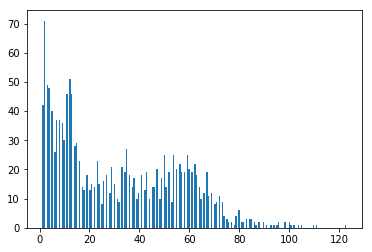

In [30]:
from matplotlib import pyplot as plt

plt.hist(player.memory.sparsity_lengths, 200)